## Covnet
- main use case is imagery
- traditionally used for image tasks but appear to be outperforming recurrent neural networks for sequential data
- you typically mix covnet layers with fully connected layers
- covnet accepts 2-d or 3-d input, no need to flatten it

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pickle
import torch

REBUILD_DATA = True




In [2]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      e
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.3.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [21]:
import torch

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Create data and send it to the device
x = torch.rand(size=(3, 4)).to(device)
x

/Users/aidanobrien/pytorch-test/env/lib/python3.8/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  nonzero_finite_vals = torch.masked_select(


tensor([[0.2399, 0.4899, 0.3055, 0.4047],
        [0.3282, 0.5519, 0.0095, 0.1816],
        [0.6065, 0.7110, 0.8499, 0.0763]], device='mps:0')

## Define class 
#### need to preprocess the datasets
- we could resize and pad with open_cv or we could
- we could rotate or flip images, multiply our data
- 

In [22]:
class DogsVSCats():
    ##condenae images to fifty by fifty
    IMG_SIZE = 50
    #define file paths
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    #define classes
    LABELS = {CATS: 0, DOGS: 1}
    # we will populate this with cats with their labels and dogs with their labels
    training_data = []
    ## need to make sure there is balance
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        #iterate of image directories
        for label in self.LABELS: 
            print(label)
            #tqdm creates a progress bar to show where you are in training
            #iterate over all images
            for f in tqdm(os.listdir(label)):     
                try:
                    path = os.path.join(label, f)
                    #convert to grayscale
                    #get rid of color, unnecessary added data
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    # Usin one hot vector
                    one_hot = np.eye(2)[self.LABELS[label]]
                    self.training_data.append([np.array(img), one_hot])
                    
                    if label == self.CATS:
                        self.catcount += 1
                    else:
                        self.dogcount += 1
                        # print string(e)
                except Exception as e:
                    pass
        
        np.random.shuffle(self.training_data)
        
        
    
        print(self.training_data)
        
        with open("training_data.pkl", "wb") as f:
            pickle.dump(self.training_data, f)
        
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|██████████| 12501/12501 [00:09<00:00, 1312.38it/s]


PetImages/Dog


 37%|███▋      | 4620/12501 [00:03<00:06, 1169.28it/s]


KeyboardInterrupt: 

## load in data

In [3]:
file = open('training_data.pkl', 'rb')

training_data = pickle.load(file)
file.close()
print(len(training_data))



24946


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #channel is 1 (no color, not RGB), outputs 32 convolutional features, 5 by 5 window
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #-1, 1, 50, 50 is the shape of the tensor that we have
        x = torch.randn(50, 50).view(-1,1,50,50)
        
        self._to_linear = None
        
        self.convs(x)
        
        #getting the flattened data from the convolutional features
        self.fc1  = nn.Linear(self._to_linear, 512)
        self.f2  = nn.Linear(512, 2)
    # just like the forward method but onlyt running it through the conv lauers
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        #have to run this first to see the dimension that we are flattening the data to
        if self._to_linear is None:
            ##x[0] means the first element in the batch of data
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x 
    def forward(self, x):
        x = self.convs(x)
        #flatten data
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.f2(x)
        return F.softmax(x, dim=1)
net = Net()


In [5]:
device = torch.device("mps")
net.to("mps")
device



device(type='mps')

In [8]:
import torch.optim as optim


EPOCHS = 3

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 ##scaling down the pixel values
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 #test against 10 percent of our training data

val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [12]:
train_X = X[:-val_size].to(device)
train_Y = y[:-val_size].to(device)
test_X = X[-val_size:].to(device)
test_Y = y[-val_size:].to(device)

BATCH_SIZE = 100
EPOCHS = 30
def train():
    for epoch in range(EPOCHS):
        #split the data into batches of 100 elements
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(i, i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_Y = train_Y[i:i+BATCH_SIZE]
            net.zero_grad()
            #send the batch through the network
            outputs = net(batch_X)
            #pass through the loss function
            loss = loss_function(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            torch.mps.empty_cache() 
        print(f"Epoch: {epoch}, Loss: {loss}")
            

In [37]:
def test():
    correct = 0 
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_Y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))

## we would like to do test every every epoch or batch, so we are going to breakdown the above functions

In [10]:
##by default we will not update weights
def fwd_pass(X, Y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, Y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, Y)
    if train:
        loss.backward()
        optimizer.step()
    torch.mps.empty_cache() 
    return acc, loss

## this is our basic test

In [15]:

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
def new_test(size=100):
    random_start = np.random.randint(len(test_X)-size)
    X, Y = test_X[random_start:random_start+32], test_Y[random_start:random_start+32]
    ## makes sure you do not call Tensor.backward(), not sure if this is needed
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50), Y)
    return val_acc, val_loss
val_acc, val_loss = new_test(size=32)   
print(val_acc, val_loss) ##by default we will not update weights

0.5 tensor(0.2501, device='mps:0')


/Users/aidanobrien/pytorch-test/env/lib/python3.8/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  nonzero_finite_vals = torch.masked_select(


## now we want to log our in sample and out of sample accuracy and loss as we go

In [17]:
import time
MODEL_NAME = f"model-{int(time.time())}"

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)
def train():
    BATCH_SIZE = 100
    EPOCHS = 30
    with open("model30.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_Y = train_Y[i:i+BATCH_SIZE]
                acc, loss = fwd_pass(batch_X, batch_Y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = new_test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

model-1720919130


In [18]:
train()

100%|█████████████████████████████████████████| 225/225 [00:14<00:00, 15.07it/s]


In [19]:
import pandas as pd
df = pd.read_csv('model.csv')
df.head()

,model,time,acc,loss,val_acc,val_loss
0,model-1720839340,1.720839e+09,0.49,0.2506,0.50,0.2552
1,model-1720839340,1.720839e+09,0.39,0.2728,0.56,0.2488
2,model-1720839340,1.720839e+09,0.53,0.2497,0.53,0.2492
3,model-1720839340,1.720839e+09,0.58,0.2459,0.53,0.2505
4,model-1720839340,1.720839e+09,0.48,0.2541,0.53,0.2482


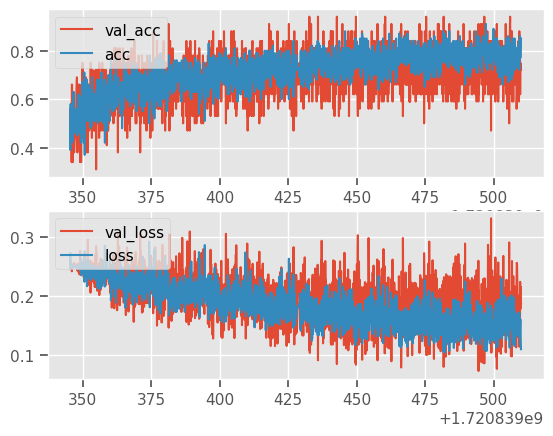

In [16]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")
model_name = "model-1720839340"

pfig = plt.figure()

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

ax1.plot(df['time'], df['val_acc'], label="val_acc")
ax1.plot(df['time'], df['acc'], label="acc")
ax1.legend(loc=2)

ax2.plot(df['time'], df['val_loss'], label="val_loss")
ax2.plot(df['time'], df['loss'], label="loss")
ax2.legend(loc=2)
plt.show()




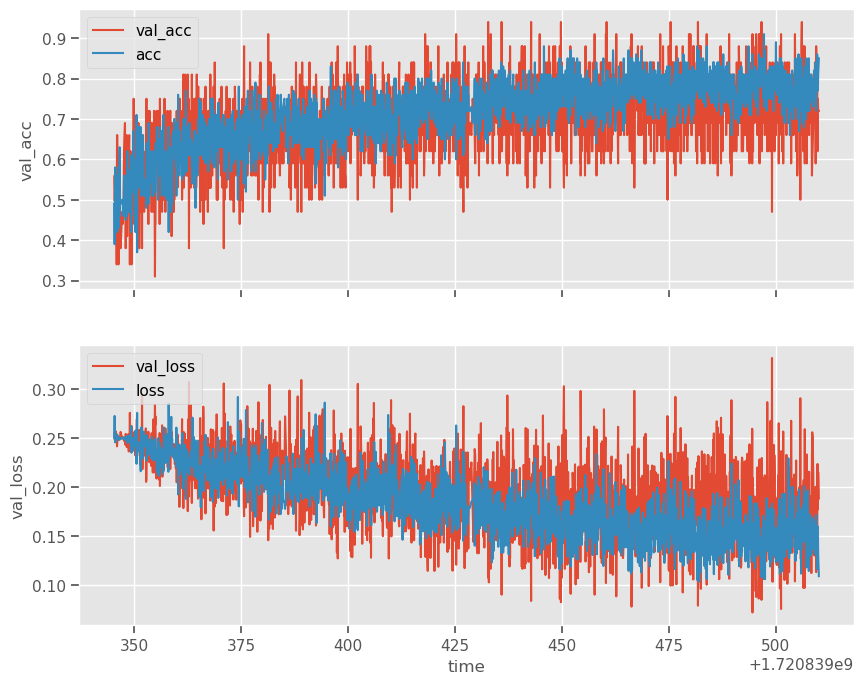

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use('ggplot')
model_name = "model-1720839340"


# Create the figure and axes
pfig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot with seaborn
sns.lineplot(ax=ax1, x='time', y='val_acc', data=df, label="val_acc")
sns.lineplot(ax=ax1, x='time', y='acc', data=df, label="acc")

sns.lineplot(ax=ax2, x='time', y='val_loss', data=df, label="val_loss")
sns.lineplot(ax=ax2, x='time', y='loss', data=df, label="loss")

# Set legends
ax1.legend(loc=2)
ax2.legend(loc=2)

# Show the plot
plt.show()


In [20]:
import pandas as pd
df = pd.read_csv('model30.csv')
df.head()

,model,time,acc,loss,val_acc,val_loss
0,model-1720919130,1.720919e+09,0.49,0.2504,0.56,0.2467
1,model-1720919130,1.720919e+09,0.39,0.2618,0.56,0.2476
2,model-1720919130,1.720919e+09,0.53,0.2489,0.53,0.2495
3,model-1720919130,1.720919e+09,0.58,0.2444,0.50,0.2606
4,model-1720919130,1.720919e+09,0.48,0.2628,0.38,0.2673


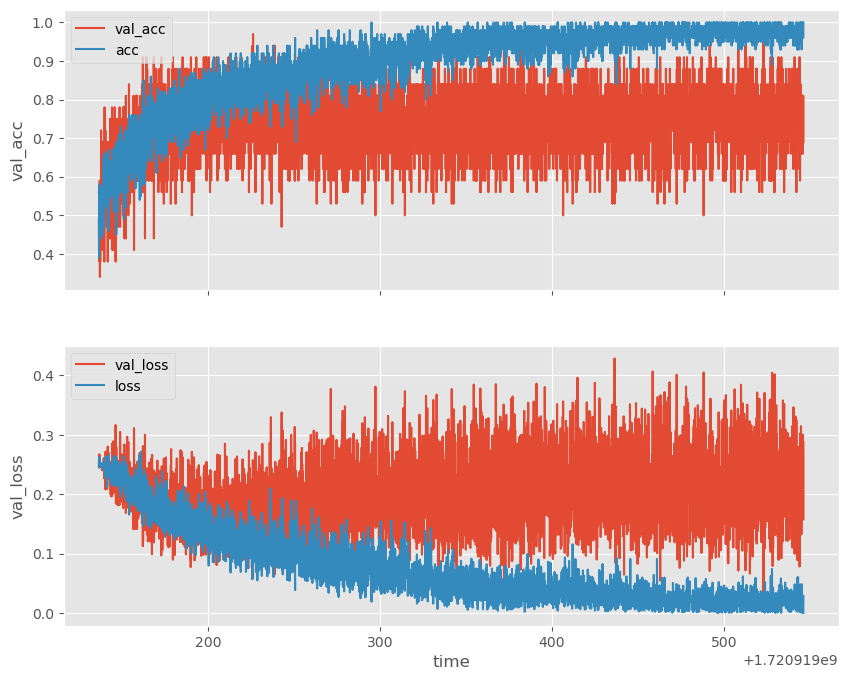

In [24]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

style.use('ggplot')
model_name = "model-1720839340"


# Create the figure and axes
pfig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot with seaborn
sns.lineplot(ax=ax1, x='time', y='val_acc', data=df, label="val_acc")
sns.lineplot(ax=ax1, x='time', y='acc', data=df, label="acc")

sns.lineplot(ax=ax2, x='time', y='val_loss', data=df, label="val_loss")
sns.lineplot(ax=ax2, x='time', y='loss', data=df, label="loss")

# Set legends
ax1.legend(loc=2)
ax2.legend(loc=2)

# Show the plot
plt.show()

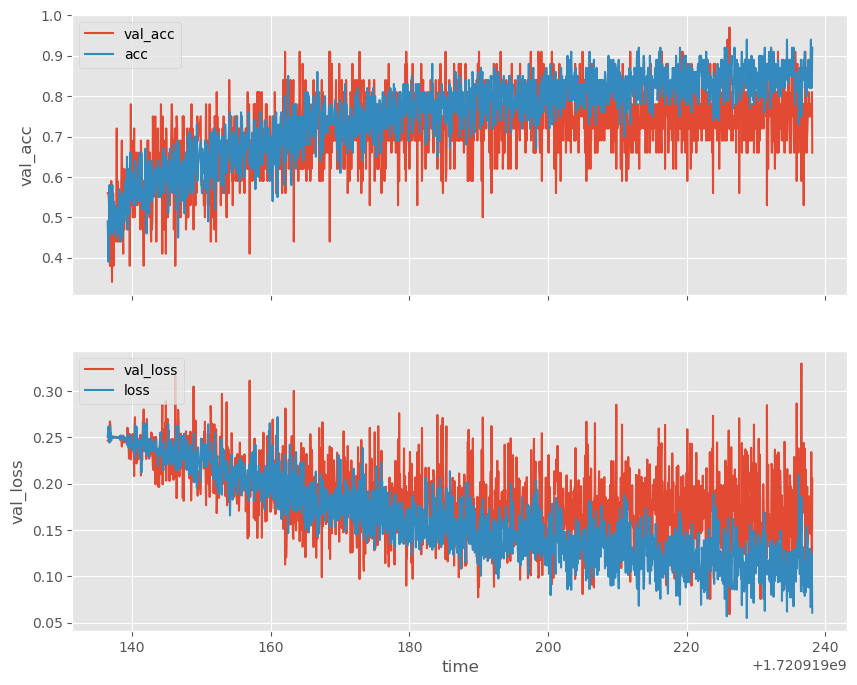

In [34]:
import math
# Calculate the index for the first third of the DataFrame
num_rows = len(df)
first_third_index = math.floor(num_rows / (30/8))

# Slice the DataFrame
df_first_third = df.iloc[:first_third_index]

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot with seaborn
sns.lineplot(ax=ax1, x='time', y='val_acc', data=df_first_third, label="val_acc")
sns.lineplot(ax=ax1, x='time', y='acc', data=df_first_third, label="acc")

sns.lineplot(ax=ax2, x='time', y='val_loss', data=df_first_third, label="val_loss")
sns.lineplot(ax=ax2, x='time', y='loss', data=df_first_third, label="loss")

# Set legends
ax1.legend(loc=2)
ax2.legend(loc=2)